In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm
import random
import transformers
import baukit

import os
import sys
sys.path.append("..")

from util import model_utils, misc
from operator import itemgetter

/data/arnab_sen_sharma/miniconda3/envs/engine/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /data/arnab_sen_sharma/miniconda3/envs/engine/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


## Loading the model

In [3]:
weights_path = "/data/arnab_sen_sharma/weights"

# facebook/galactica-6.7b  
# gpt2-{medium,large,xl}
# EleutherAI/gpt-j-6B

# MODEL_NAME = "EleutherAI/gpt-j-6B"
MODEL_NAME = "llama-13b-hf"
MODEL_NAME = f"{weights_path}/{MODEL_NAME}"
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=True, torch_dtype=torch.float16)

model = mt.model
tokenizer = mt.tokenizer
# tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

print(f"{MODEL_NAME} ==> device: {model.device}, memory: {model.get_memory_footprint()}")

Loading checkpoint shards:   0%|          | 0/41 [00:00<?, ?it/s]

/data/arnab_sen_sharma/weights/llama-13b-hf ==> device: cuda:0, memory: 26115624960


In [6]:
input_text = "baseball baseball Megan Rapione plays the sport of"
tokenized = tokenizer(input_text, return_tensors="pt")

outputs = model.generate(tokenized.input_ids.to(model.device), max_new_tokens=20, top_k = 1)
print(tokenizer.decode(outputs[0]))

 baseball baseball Megan Rapione plays the sport of baseball. She is a pitcher and plays for the varsity team. She has been playing baseball


In [7]:
txt, ret_dict = model_utils.generate_fast(
    model = model, tok = tokenizer,
    prompts = input_text,
    argmax_greedy= True,
#     debug=True,
    max_new_tokens=30,
    top_k = 5
)

txt

[' baseball baseball Megan Rapione plays the sport of baseball. She is a pitcher and plays for the varsity team. She has been playing baseball since she was 10 years old. She']

In [6]:
# prompts = [
#     "Michael Jordan is a",
#     "Eiffel Tower is lcoated in the city of"
# ]

# model_utils.generate_fast(
#     model, tokenizer,
#     prompts,
#     argmax_greedy=True  
# )

In [7]:
# tokenized = tokenizer(prompts, return_tensors="pt", padding = True).to(model.device)
# tokenized

In [8]:
# with baukit.TraceDict(
#     model, layers=[mt.layer_names[14]]
# ) as traces:  
#     output = model(**tokenized)

In [8]:
tokenizer.tokenize("1773")

['▁', '1', '7', '7', '3']

In [25]:
born_on_prompt = "President {} was born on the year of "
died_on_prompt = "President {} died on the year of"
president = "William Henry Harrison"
# president = "John Quincy Adams"

txt, ret_dict = model_utils.generate_fast(
    model = model, tok = tokenizer,
#     prompts = born_on_prompt.format(president),
    prompts = died_on_prompt.format(president),
#     prompts = "Paris, Paris, Paris, Paris, The capital of the USA is the city of",
    argmax_greedy= True,
    max_new_tokens=30,
    top_k = 5,
#     debug = True
)

txt

/data/arnab_sen_sharma/Projects/relations/notebooks/../util/model_utils.py:198: UserWarning: The model `<class 'transformers.models.llama.modeling_llama.LlamaForCausalLM'>` can't utilize `use_cache` for fast generation. Setting `use_cache = False`.
  warnings.warn(f"The model `{type(model)}` can't utilize `use_cache` for fast generation. Setting `use_cache = False`.")


[' President William Henry Harrison died on the year of 1841. He was the ninth president of the United States. He was born on February 9, 1773']

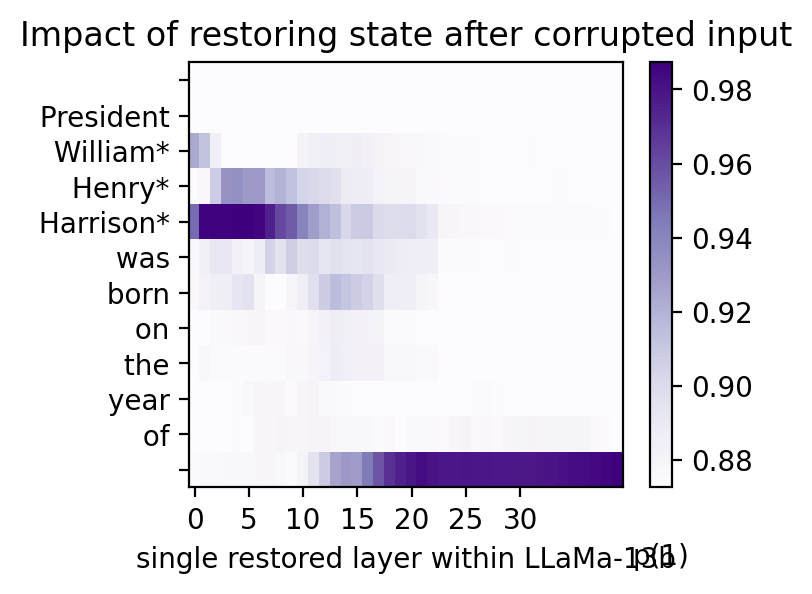

In [26]:
plot_hidden_flow(mt, born_on_prompt.format(president), president.replace(" ", ""), modelname = "LLaMa-13b")

## Testing for disambiguating relations

In [9]:
sample = [
#     {"fruit": "apple", "inside": "white", "outside": "red"},
    {"fruit": "watermelon", "inside": "red", "outside": "green"},
    {"fruit": "banana", "inside": "white", "outside": "yellow"},
    {"fruit": "coconut", "inside": "white", "outside": "brown"},
#     {"fruit": "kiwi", "inside": "green", "outside": "brown"},
    {"fruit": "cantaloupe", "inside": "orange", "outside": "green"},
    {"fruit": "blood orange", "inside": "red", "outside": "orange"},
    {"fruit": "eggplant", "inside": "white", "outside": "purple"},
    {"fruit": "dragonfruit", "inside": "white", "outside": "pink"},
    {"fruit": "lime", "inside": "white", "outside": "green"},
    {"fruit": "radish", "inside": "white", "outside": "red"},
    {"fruit": "salak", "inside": "white", "outside": "brown"},
    {"fruit": "potato", "inside": "white", "outside": "brown"},
]

In [10]:
# prompts = [
#     "What color is the inside of a coconut? It is",
#     "What color is the outside of a coconut? It is",
    
#     "What color is the inside of a watermelon? It is",
#     "What color is the outside of a watermelon? It is",
    
#     "What color is the inside of a kiwi? It is",
#     "What color is the outside of a kiwi? It is",
# ]

icl_inside = """the color on the inside of a apple is white
the color on the inside of a kiwi is green
the color on the inside of a {} is"""

icl_outside = """the color on the outside of a apple is red
the color on the outside of a kiwi is brown
the color on the outside of a {} is"""


for fruit in sample:
    name = fruit["fruit"]
    print(fruit)
    prompts = [icl_inside.format(name), icl_outside.format(name)]
    txt, ret_dict = model_utils.generate_fast(
        model = model, tok = tokenizer,
        prompts = prompts,
        argmax_greedy= True,
        max_new_tokens=5,
        top_k = 5,

        get_answer_tokens = True
    )
    
    inside_pred = [(c["token"], c["token_id"], c["p"]) for c in ret_dict["answer"][0]['candidates']]
    outside_pred = [(c["token"], c["token_id"], c["p"]) for c in ret_dict["answer"][1]['candidates']]
    
    print(name)
    print(f"inside >> {fruit['inside']} || {inside_pred}")
    print(f"outside >> {fruit['outside']} || {outside_pred}")
    print()


{'fruit': 'watermelon', 'inside': 'red', 'outside': 'green'}
watermelon
inside >> red || [(' red', 2654, 0.3896), (' white', 4796, 0.2021), (' p', 282, 0.187), (' green', 7933, 0.0527), (' yellow', 13328, 0.0357)]
outside >> green || [(' green', 7933, 0.5083), (' red', 2654, 0.1389), (' p', 282, 0.1082), (' black', 4628, 0.0386), (' yellow', 13328, 0.031)]

{'fruit': 'banana', 'inside': 'white', 'outside': 'yellow'}
banana
inside >> white || [(' yellow', 13328, 0.5303), (' white', 4796, 0.2793), (' green', 7933, 0.0313), (' black', 4628, 0.0186), (' brown', 17354, 0.013)]
outside >> yellow || [(' yellow', 13328, 0.6807), (' green', 7933, 0.1147), (' brown', 17354, 0.0893), (' black', 4628, 0.0215), (' red', 2654, 0.0089)]

{'fruit': 'coconut', 'inside': 'white', 'outside': 'brown'}
coconut
inside >> white || [(' white', 4796, 0.6724), (' yellow', 13328, 0.0731), (' brown', 17354, 0.0698), (' orange', 24841, 0.0234), (' green', 7933, 0.0211)]
outside >> brown || [(' brown', 17354, 0.474

In [11]:
tokenized = tokenizer("coconut")
[tokenizer.decode(t) for t in tokenized.input_ids]

[' <s>', ' co', ' con', ' ut']

In [12]:
mt.layer_name_format

'model.layers.{}'

## Representation Swapping

In [13]:
from relations.estimate import _find_token_range_without_offset_mapping
from util.misc import untuple

def interpret_model_output(output):
    token_ids = output.logits[0][-1].argsort()[-10:]
    logits = output.logits[0][-1][token_ids]
    proba = torch.nn.functional.softmax(output.logits[0][-1], dim = 0)[token_ids]

    return [
        (tokenizer.decode(t), l.item(), p.item()) for t, l, p in zip(token_ids, logits, proba)
    ][::-1]

def get_replace_intervention(
    intervention_layer,
    tpos_to_replace, # a dictionalry token_pos to replacement
):
    def intervention(output, layer):
        if(layer != intervention_layer):
            return output
        for tpos in tpos_to_replace:
            output[0][0][tpos] = torch.tensor(tpos_to_replace[tpos]).to(output[0].dtype).to(output[0].device)
            
        return output
    
    return intervention

In [14]:
subject_o = "coconut"
subject_c = "watermelon"

prompt_o = icl_inside.format(subject_o)
prompt_c = icl_inside.format(subject_c)
# prompt_o = "what is the color on the inside of a {}? It is".format(subject_o)

tokenized_o = tokenizer(prompt_o, return_tensors = "pt").to(model.device)
tokenized_c = tokenizer(prompt_c, return_tensors = "pt").to(model.device)

In [47]:
# from util.causal_tracing import find_token_range

# find_token_range(tokenizer, tokenized_o["input_ids"][0], subject_o)
# _find_token_range_without_offset_mapping(
#     subject_o, [tokenizer.decode(t) for t in tokenized_o["input_ids"][0]]
# )

In [15]:
range_o = _find_token_range_without_offset_mapping(
    subject_o,
    [tokenizer.decode(t) for t in tokenized_o.input_ids[0]]
)
range_o = range(range_o[0], range_o[1])

range_c = _find_token_range_without_offset_mapping(
    subject_c,
    [tokenizer.decode(t) for t in tokenized_c.input_ids[0]]
)
range_c = range(range_c[0], range_c[1])

print(range_o)
print(range_c)

range(31, 34)
range(31, 35)


In [16]:
with baukit.TraceDict(
    model, layers = [mt.layer_name_format.format(l) for l in range(2, 10)]
) as traces_o:
    output_o = model(**tokenized_o)
    
with baukit.TraceDict(
    model, layers = [mt.layer_name_format.format(l) for l in range(2, 10)]
) as traces_c:
    output_c = model(**tokenized_c)

In [17]:
interpret_model_output(output_c)

[(' red', 18.53125, 0.385986328125),
 (' white', 17.890625, 0.2034912109375),
 (' p', 17.8125, 0.1881103515625),
 (' green', 16.546875, 0.053070068359375),
 (' yellow', 16.15625, 0.035919189453125),
 (' black', 15.734375, 0.0235443115234375),
 (' a', 14.671875, 0.00814056396484375),
 (' pur', 14.34375, 0.005863189697265625),
 (' light', 14.3046875, 0.00563812255859375),
 (' orange', 14.1875, 0.005016326904296875)]

In [29]:
layer = 5
range_sub_to_replace = range(-2, 0)
o_token_pos_to_replace = {}

for idx in list(range_sub_to_replace):
    o_token_pos_to_replace[list(range_o)[idx]] = untuple(
        traces_c[mt.layer_name_format.format(layer)].output
    )[0][list(range_c)[idx]]

for k in o_token_pos_to_replace:
    print(k, o_token_pos_to_replace[k].shape)

32 torch.Size([5120])
33 torch.Size([5120])


In [30]:
with baukit.TraceDict(
    model, layers = [mt.layer_name_format.format(l) for l in range(2, 10)],
    edit_output = get_replace_intervention(mt.layer_name_format.format(layer), o_token_pos_to_replace)
) as traces_int:
    output_int = model(**tokenized_o)

/tmp/ipykernel_249144/3978198821.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output[0][0][tpos] = torch.tensor(tpos_to_replace[tpos]).to(output[0].dtype).to(output[0].device)


In [31]:
interpret_model_output(output_int)

[(' red', 18.375, 0.320068359375),
 (' white', 18.25, 0.282470703125),
 (' p', 17.671875, 0.158447265625),
 (' green', 16.578125, 0.053070068359375),
 (' yellow', 16.5625, 0.05224609375),
 (' orange', 15.4765625, 0.01763916015625),
 (' black', 15.3984375, 0.0163116455078125),
 (' a', 14.6796875, 0.0079498291015625),
 (' pur', 14.0625, 0.0042877197265625),
 (' light', 14.0390625, 0.00418853759765625)]

In [ ]:
hiddenflow_collection = []

for 

## Causal Tracing of disambiguating relations

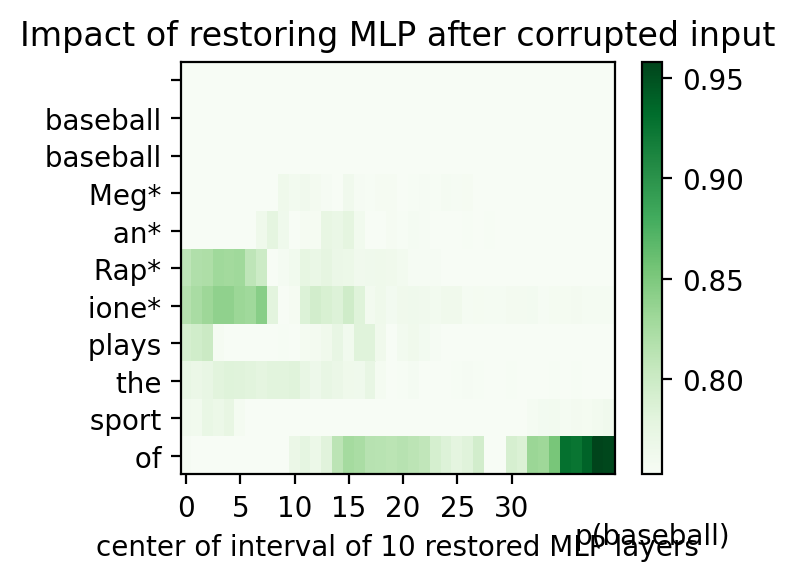

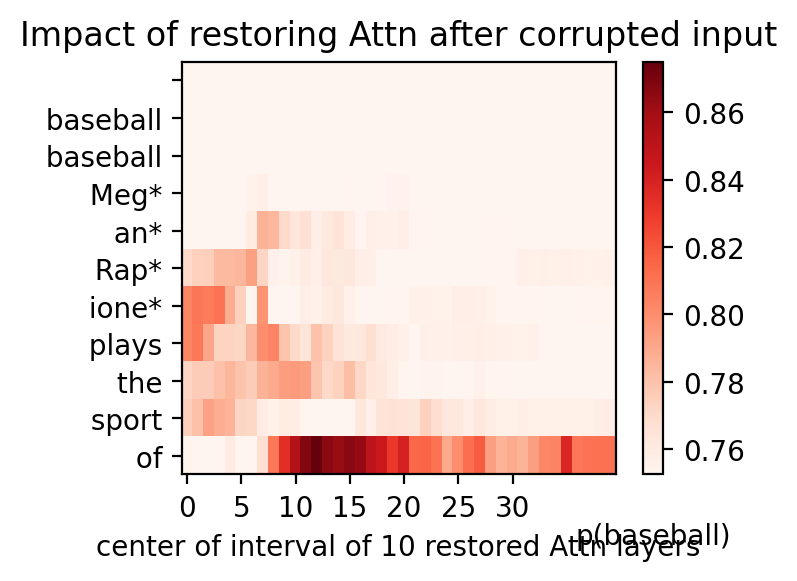

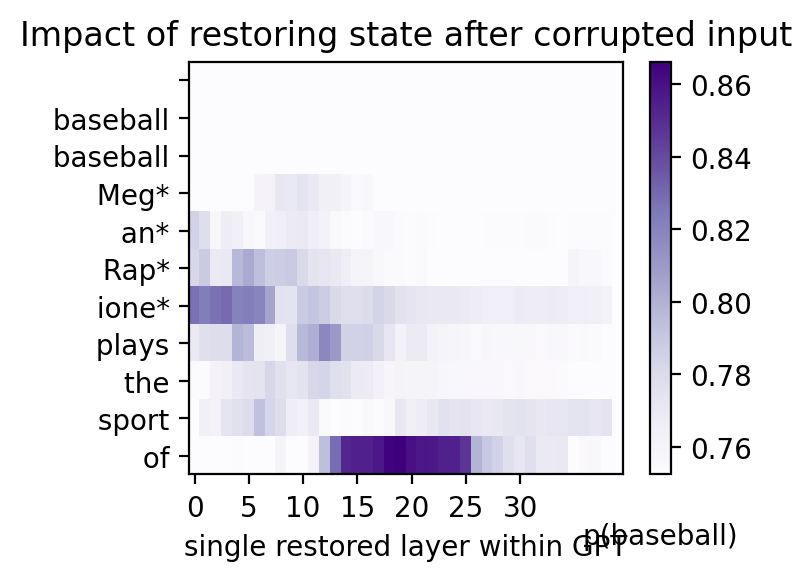

In [9]:
from util.causal_tracing import (
    predict_token,
    guess_subject,
    find_token_range,
    calculate_hidden_flow,
    plot_trace_heatmap,
    plot_hidden_flow,
    plot_all_flow
)


# prompt = "The Space Needle is located in the city of"
# tokenized = tokenizer([prompt], return_tensors = "pt", padding = True).to(model.device)
# output = model(**tokenized)
# output["logits"]

# predict_token(mt, [prompt], return_p = True)
# subject = guess_subject(prompt).replace(" ", "")
# print(subject)

# find_token_range(tokenizer, tokenized["input_ids"][0], subject)

plot_all_flow(mt, "baseball baseball Megan Rapione plays the sport of", subject = "Megan Rapione".replace(" ", ""))


In [48]:
subject = "coconut"
prompt = icl_inside.format(subject)
# prompt = "What is the color on the inside of a {}? It is".format(subject)

# plot_hidden_flow(mt, prompt, subject, modelname = "LLaMa-13b")

In [49]:
hidden_flow = calculate_hidden_flow(mt, prompt, subject)

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

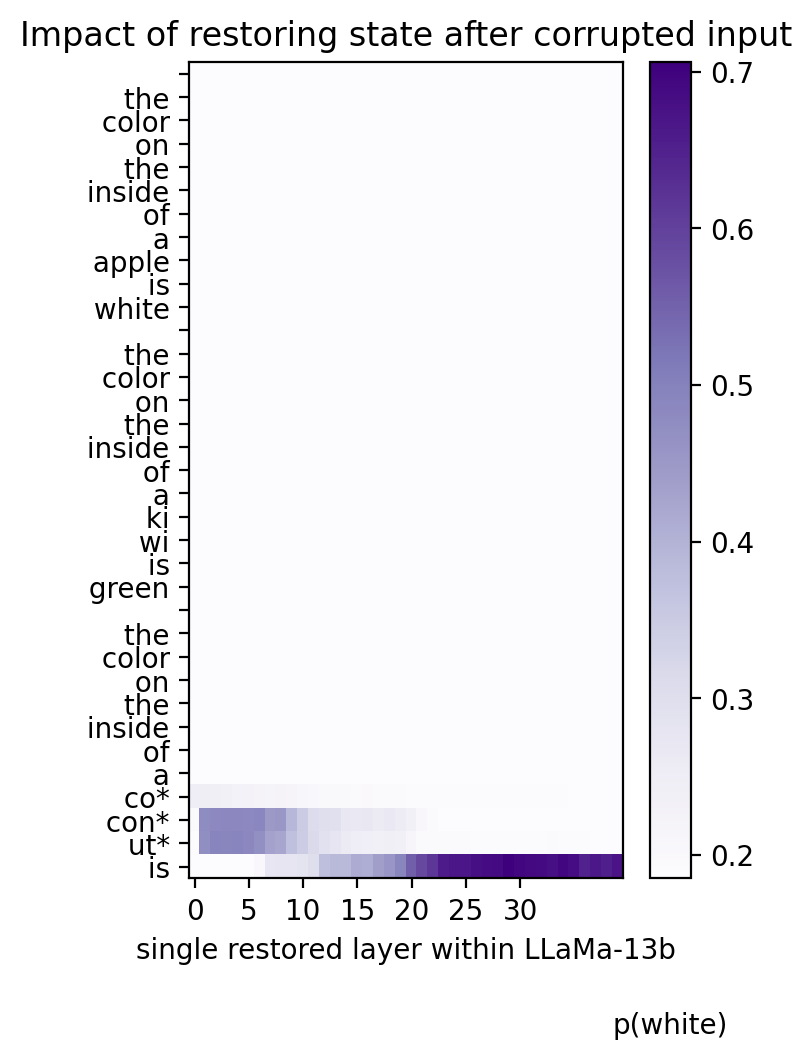

In [50]:
plot_trace_heatmap(hidden_flow, modelname = "LLaMa-13b")

In [ ]:
# plot_all_flow(mt, prompt, subject, modelname = "LLaMa-13b")

In [ ]:
prompt_2 = "What is the color on the outside of a {}? It is".format(subject)
# hidden_flow_2 = calculate_hidden_flow(mt, prompt_2, subject)

In [ ]:
# plot_trace_heatmap(hidden_flow_2, modelname = "LLaMa-13b")

In [ ]:
plot_hidden_flow(mt, prompt_2, subject, modelname = "LLaMa-13b")

In [83]:
import copy

def detensorize(hiddenflow):
    hf = copy.deepcopy(hidden_flow)
    for k in hf:
        if isinstance(hf[k], torch.Tensor):
            hf[k] = hf[k].item() if k == "high_score" else hf[k].cpu().numpy().tolist()
    return hf

In [84]:
hidden_flow_collection = {}
for s in tqdm(sample):
    fruit = s['fruit']
    hidden_flow = calculate_hidden_flow(mt, icl_inside.format(fruit), fruit)
    hidden_flow_collection[fruit] = detensorize(hidden_flow)

  0%|          | 0/11 [00:00<?, ?it/s]

ValueError: I/O operation on closed file.

In [91]:
hidden_flow

{'scores': tensor([[0.2079, 0.2079, 0.2079,  ..., 0.2079, 0.2079, 0.2079],
         [0.2079, 0.2079, 0.2079,  ..., 0.2079, 0.2079, 0.2079],
         [0.2079, 0.2079, 0.2079,  ..., 0.2079, 0.2079, 0.2079],
         ...,
         [0.2771, 0.2710, 0.2377,  ..., 0.2100, 0.2074, 0.2079],
         [0.3237, 0.7368, 0.7388,  ..., 0.2124, 0.2096, 0.2079],
         [0.2094, 0.2108, 0.2123,  ..., 0.6885, 0.6953, 0.7075]],
        dtype=torch.float16),
 'low_score': 0.2078857421875,
 'high_score': tensor(0.7075, device='cuda:0', dtype=torch.float16),
 'input_ids': tensor([    1,   278,  2927,   373,   278,  2768,   310,   263, 26163,   338,
          4796,    13,  1552,  2927,   373,   278,  2768,   310,   263,  8506,
          4353,   338,  7933,    13,  1552,  2927,   373,   278,  2768,   310,
           263,  3104,  1219,   338], device='cuda:0'),
 'input_tokens': [' ',
  ' the',
  ' color',
  ' on',
  ' the',
  ' inside',
  ' of',
  ' a',
  ' apple',
  ' is',
  ' white',
  ' \n',
  ' the',
  '

In [85]:
with open("causal_traces.json", "w") as f:
    json.dump(hidden_flow_collection, f)

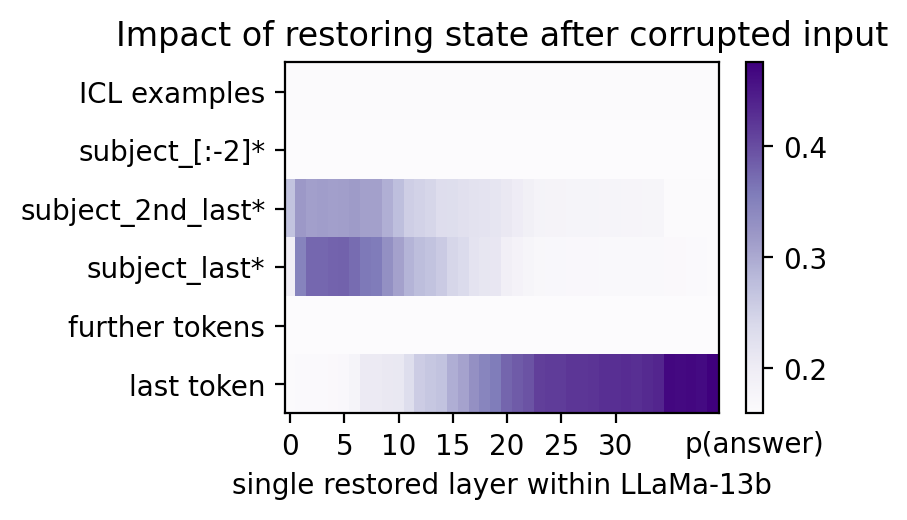

In [141]:
hf_all = {
    'input_tokens': [
        'ICL examples',
        'subject_[:-2]',
        'subject_2nd_last',
        'subject_last',
        'further tokens',
        'last token'
    ],
    'answer': "answer"
}

icl_examples = []
low_scores = []
subject_first = []
subject_2nd_last = []
subject_last = []
further_tokens = []
last_token = []
for fruit in hidden_flow_collection:
    result = hidden_flow_collection[fruit]
    differences = torch.tensor(result["scores"])
    icl_examples.append(differences[: result['subject_range'][0]].mean(dim = 0))
    low_scores.append(result['low_score'])
    subject_last.append(differences[result['subject_range'][1] - 1])
    subject_2nd_last.append(differences[result['subject_range'][1] - 2])
#     print(result['subject_range'],  result['subject_range'][1] - 2, differences.shape)
    if(result['subject_range'][1] - 2 != result['subject_range'][0]):
        subject_first.append(differences[result['subject_range'][0] : result['subject_range'][1] - 2].mean(dim=0))
    else:
        subject_first.append(torch.zeros(differences.shape[1]))
    last_token.append(differences[-1])
    if(result['subject_range'][1] != len(result['input_tokens']) - 1):
        further_tokens.append(differences[result['subject_range'][1] : -1]).mean(dim = 0)
    else:
        further_tokens.append(torch.zeros(differences.shape[1]))
        
icl_examples = torch.stack(icl_examples).mean(dim = 0)
subject_first = torch.stack(subject_first).mean(dim = 0)
subject_2nd_last = torch.stack(subject_2nd_last).mean(dim = 0)
subject_last = torch.stack(subject_last).mean(dim = 0)
further_tokens = torch.stack(further_tokens).mean(dim = 0)
last_token = torch.stack(last_token).mean(dim = 0)

hf_all['low_score'] = torch.tensor(low_scores).mean()
hf_all['kind'] = None
hf_all['subject_range'] = (1,4)

hf_all['scores'] = torch.stack([
    icl_examples,
    subject_first,
    subject_2nd_last,
    subject_last,
    further_tokens,
    last_token
])

plot_trace_heatmap(hf_all, modelname = "LLaMa-13b")

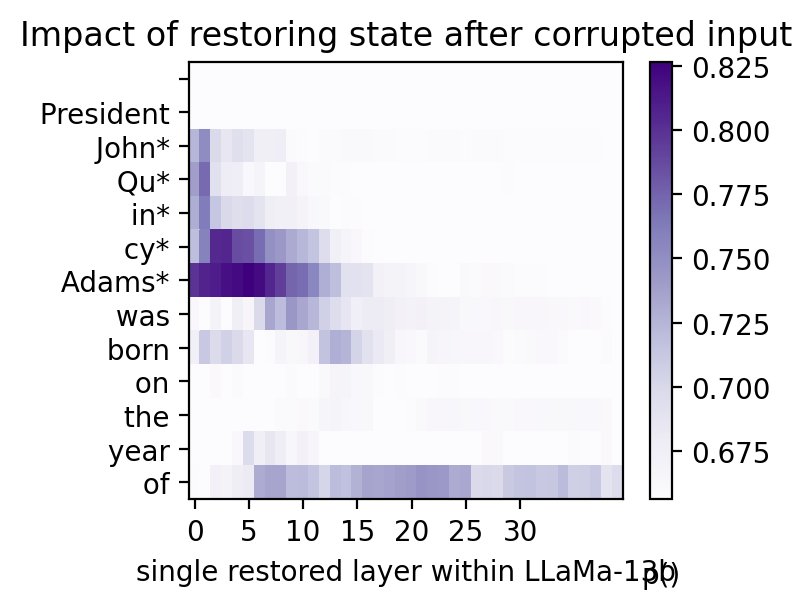

In [22]:
# subject = "Prudential Tower"
# relation = "{} is located in the city of"
plot_hidden_flow(mt, born_on_prompt.format(president), president.replace(" ", ""), modelname = "LLaMa-13b")

## Adapting the `estimate` and `corner` moduels to support `LLaMa`

In [ ]:
colors = [
    "purple", "blue", "green", "yellow", 
    "orange", "red", "violet", "white", 
    "black", "pink", "brown", "grey"
]

for c in colors:
    word = c
    tok_ids = tokenizer(word).input_ids
    print(list(zip(tok_ids, [tokenizer.decode(t) for t in tok_ids])))

In [ ]:
ln_f_name = "model.norm"
unembedder_module_name = "lm_head"

ln_f = baukit.get_module(model, ln_f_name)
unembedder = baukit.get_module(model, unembedder_module_name)

In [ ]:
from relations.corner import CornerEstimator

corner_estimator = CornerEstimator(
    model, tokenizer,
    ln_f_name = "model.norm", unembedder_module_name = "lm_head",
    idx = 1
)

In [ ]:
corner = corner_estimator.estimate_corner_with_gradient_descent(
    target_words = colors, target_logit_value = 30, verbose = True
)

In [ ]:
from relations import estimate

In [ ]:
subject = "watermelon"
relation = icl_inside

rop, _ = estimate.relation_operator_from_sample(
    model, tokenizer,
    subject = subject, relation = relation,
    layer = 20,
    
    layer_name_format = "model.layers.{}",
    ln_f_name = "model.norm",
    unembedder_module_name = "lm_head",
    n_layer_field = 'num_hidden_layers',
    device = "cuda:0"
)

In [ ]:
misc.visualize_matrix(rop.weight)

In [ ]:
corner_estimator.get_vocab_representation(rop.bias, get_logits = True)

In [ ]:
rop_2, _ = estimate.relation_operator_from_sample(
    model, tokenizer,
    subject = subject, relation = relation,
    layer = 20,
    
    layer_name_format = "model.layers.{}",
    ln_f_name = "model.norm",
    unembedder_module_name = "lm_head",
    n_layer_field = 'num_hidden_layers',
    device = "cuda:1",
    calculate_J_sequentially_row_by_row = True
)


In [ ]:
misc.visualize_matrix(rop_2.weight)

In [ ]:
corner_estimator.get_vocab_representation(rop_2.bias, get_logits = True)

In [ ]:
torch.dist(rop.weight, rop_2.weight.to(rop.weight.device))

## Averaging multiple `relation_operators`

In [ ]:
from tqdm.auto import tqdm

In [ ]:
train_samples = ["watermelon", "coconut"]
layer = 5


inside_weights = []
outside_weights = []

for fruit in tqdm(train_samples):
    rop_inside, _ = estimate.relation_operator_from_sample(
        model, tokenizer,
        subject = fruit, relation = icl_inside,
        layer = layer,
        layer_name_format = "model.layers.{}", ln_f_name = "model.norm", 
        unembedder_module_name = "lm_head", n_layer_field = 'num_hidden_layers',
        device = "cuda:0"
    )
    inside_weights.append(rop_inside)
    
    rop_outside, _ = estimate.relation_operator_from_sample(
        model, tokenizer,
        subject = fruit, relation = icl_outside,
        layer = layer,
        layer_name_format = "model.layers.{}", ln_f_name = "model.norm", 
        unembedder_module_name = "lm_head", n_layer_field = 'num_hidden_layers',
        device = "cuda:0"
    )
    outside_weights.append(rop_outside)

In [ ]:
color_inside = estimate.RelationOperator(
    model = model, tokenizer= tokenizer,
    relation = icl_inside, layer = layer,
    weight = torch.stack(
        [wb.weight for wb in inside_weights]
    ).mean(dim=0),
    bias = corner,
#     bias = torch.stack([wb.bias for wb in inside_weights]).mean(dim=0),
    layer_name_format = "model.layers.{}", ln_f_name = "model.norm", 
    unembedder_module_name = "lm_head",
)

In [ ]:
misc.visualize_matrix(color_inside.weight)

In [ ]:
corner_estimator.get_vocab_representation(
    torch.stack([wb.bias for wb in inside_weights]).mean(dim=0), 
    get_logits = True
)

In [ ]:
color_inside(
    subject = "egg",
    subject_token_index = -1, device = "cuda:0", return_top_k = 5
)

In [ ]:
color_outside = estimate.RelationOperator(
    model = model, tokenizer= tokenizer,
    relation = icl_inside, layer = layer,
    weight = torch.stack(
        [wb.weight for wb in outside_weights]
    ).mean(dim=0),
    bias = corner,
#     bias = torch.stack([wb.bias for wb in outside_weights]).mean(dim=0),
    layer_name_format = "model.layers.{}", ln_f_name = "model.norm", 
    unembedder_module_name = "lm_head",
)

In [ ]:
misc.visualize_matrix(color_outside.weight)

In [ ]:
corner_estimator.get_vocab_representation(
    torch.stack([wb.bias for wb in outside_weights]).mean(dim=0), 
    get_logits = True
)

In [ ]:
color_outside(
    subject = "egg",
    subject_token_index = -1, device = "cuda:0", return_top_k = 5
)

In [ ]:
torch.dist(color_inside.weight, color_outside.weight)